# Creating a dataset for stroke presence prediction

Method: split whole brain into two hemispheres - one with stroke and one without
Rationale: Create dataset for hemispheric stroke presence classification to determine which topological features are most useful for vascular imaging


In [7]:
import sys
path_bnd = '../'
sys.path.insert(1, path_bnd)
import analysis_tools.data_loader as dl
from gsprep.visual_tools.visual import display, idisplay
from gsprep.visual_tools.dataset_visualization import visualize_dataset
import matplotlib.pyplot as plt
import numpy as np

## Import data

In [2]:
data_dir = '/Users/julian/stroke_research/brain_and_donuts/full_datasets'
filename = 'withAngio_all_2016_2017.npz'
clinical_inputs, ct_inputs, ct_lesion_GT, mri_inputs, mri_lesion_GT, brain_masks, ids, params = \
dl.load_structured_data(data_dir, filename=filename)

# Reshape ct_inputs as it has 1 channel
ct_inputs = ct_inputs.reshape((*ct_inputs.shape[:-1]))

Loading a total of 113 subjects.
Sequences used: {'ct_sequences': ['wbetted_Angio'], 'ct_label_sequences': ['wcoreg_VOI'], 'mri_sequences': [], 'mri_label_sequences': []}
0 subjects had been excluded.


## Setting up data exploration set

In [ ]:
# Data subset
n_images = 5
subsampling_rate = 2
X = (ct_inputs[:n_images] * brain_masks[:n_images])[range(n_images), ::subsampling_rate, ::subsampling_rate, ::subsampling_rate]
y = (ct_lesion_GT[:n_images] * brain_masks[:n_images])[range(n_images), ::subsampling_rate, ::subsampling_rate, ::subsampling_rate]

print(X.shape)
print(y.shape)

In [ ]:
idisplay(X[0], mask=y[0])

Create a function to split the provided data into the two hemispheres.

In [ ]:
def brain_to_hemispheres(data, uniform_side=True):
    x_center = data.shape[1] // 2

    # split brain (here in image denomination, anatomical denomination would be the contrary)
    right_side = data[:, x_center:]
    left_side = data[:, :x_center]
    if uniform_side:
        transposed_right_side = np.flip(right_side, axis=1)
        print(transposed_right_side.shape, left_side.shape)
        hemispheres = np.concatenate((left_side, transposed_right_side), axis=0)
        print(hemispheres.shape)
        return hemispheres
    else:
        hemispheres = np.concatenate((left_side, right_side), axis=0)
        return hemispheres


In [ ]:
hemi_X, hemi_y = brain_to_hemispheres(X), brain_to_hemispheres(y)
display(hemi_X[0])
display(hemi_y[0])
display(hemi_X[1])
display(hemi_y[1])


## Transform whole dataset


In [3]:
outdir = data_dir
out_file_name = 'withAngio_hemispheres_all_2016_2017.npz'

In [4]:
dl.brain_volumes_dataset_to_hemispheric_dataset(data_dir, filename=filename, outdir=outdir, out_file_name = out_file_name)

Loading a total of 113 subjects.
Sequences used: {'ct_sequences': ['wbetted_Angio'], 'ct_label_sequences': ['wcoreg_VOI'], 'mri_sequences': [], 'mri_label_sequences': []}
0 subjects had been excluded.
Saving a total of 226 subjects.


Load newly created hemispheric dataset

In [4]:
clinical_inputs, ct_inputs, ct_lesion_GT, mri_inputs, mri_lesion_GT, brain_masks, ids, params = \
dl.load_structured_data(outdir, filename=out_file_name)
ct_inputs.shape, ct_lesion_GT.shape, ids.shape

Loading a total of 226 subjects.
Sequences used: {'ct_sequences': ['wbetted_Angio'], 'ct_label_sequences': ['wcoreg_VOI'], 'mri_sequences': [], 'mri_label_sequences': []}
0 subjects had been excluded.


((226, 39, 95, 79, 1), (226, 39, 95, 79), (226,))

Image center:  19 47 39
Image center value:  34.76788330078125
Image center:  19 47 39
Image center value:  36.72206497192383
Image center:  19 47 39
Image center value:  True


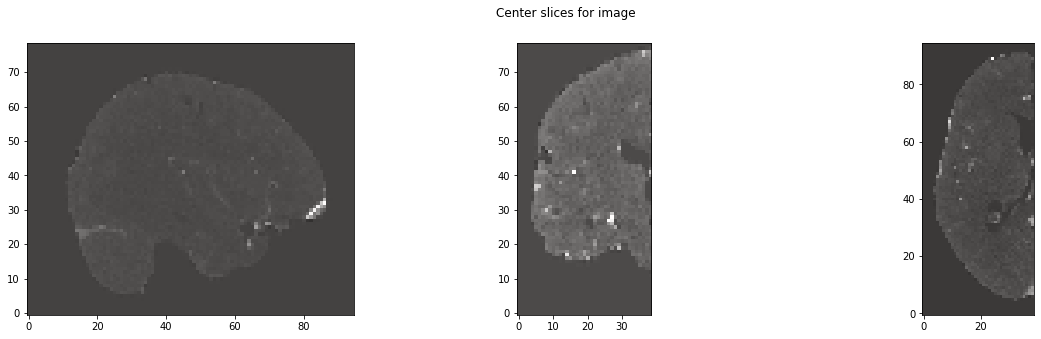

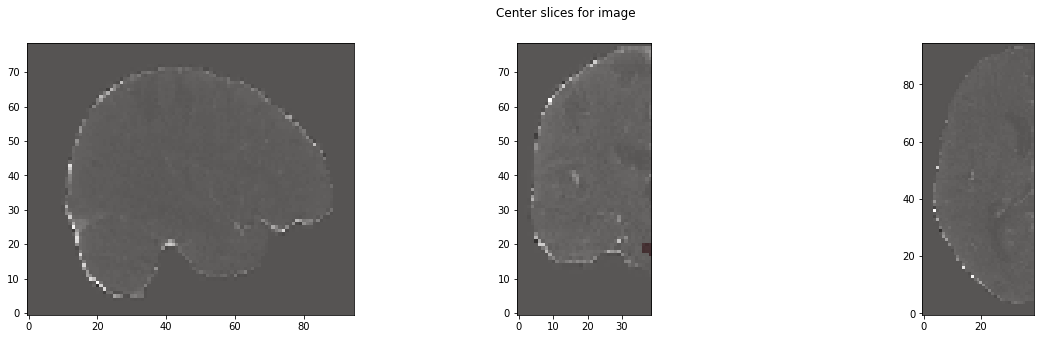

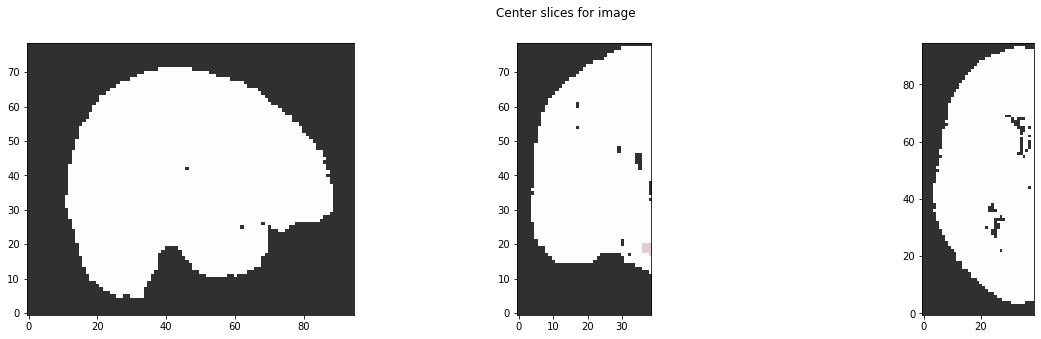

In [35]:
display(ct_inputs[0], mask=ct_lesion_GT[0])
display(ct_inputs[1], mask=ct_lesion_GT[1])

In [6]:
stroke_presence_GT = np.any(ct_lesion_GT, axis=(1,2,3))
print(f'Total number of hemispheres: {stroke_presence_GT.shape}, of which {np.sum(stroke_presence_GT)} contain a stroke lesion')

Total number of hemispheres: (226,), of which 136 contain a stroke lesion


Infarcted voxels by hemisphere. Mean: 1881.9557522123894 Std: 4043.252105788419 Min: 0.0 Max: 32362.0


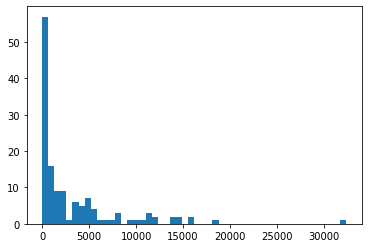

In [23]:
infarcted_voxel_count = np.sum(ct_lesion_GT, axis=(1,2,3))
plt.hist(infarcted_voxel_count[infarcted_voxel_count > 0], bins=50)
print(f'Infarcted voxels by hemisphere. Mean: {np.mean(infarcted_voxel_count)} Std: {np.std(infarcted_voxel_count)} Min: {np.min(infarcted_voxel_count)} Max: {np.max(infarcted_voxel_count)}')

Eventually, hemispheres with only very few infarcted voxels could be filtered out as they might be the result of wrong hemisphere slicing.

In [34]:
infarcted_voxel_count[infarcted_voxel_count > 20].shape

(123,)

In [19]:
data = np.concatenate((ct_inputs, ct_lesion_GT[...,None]), axis=-1)
visualize_dataset(data, ['ct', 'gt'], subject_ids=[np.any(gt) for gt in ct_lesion_GT], save_dir=outdir)


  0%|          | 0/226 [00:00<?, ?it/s]/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/gsprep/visual_tools/dataset_visualization.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(gs[i_row, i_col])
100%|██████████| 226/226 [00:11<00:00, 19.28it/s]
